**1. Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

%pip install boruta
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Pre-Processing Data**


*   Load Data




In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/Merged01.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/Merged02.csv')

* Menggabungkan File


In [ ]:
df = pd.concat([df1, df2], ignore_index=True)

* Inspeksi awal

In [ ]:
df.shape
print("Jumlah baris dan kolom:", df.shape)

Jumlah baris dan kolom: (1460896, 40)


In [ ]:
df.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


In [ ]:
df.tail()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
1460891,4.68,17,62.72,1209.336067,0.0,0.0,0.01,0.01,0.02,0.0,...,88590,60,1514,885.9,598.328471,885.9,0.000829,100,357996.959596,DDOS-UDP_FRAGMENTATION
1460892,21.20,6,151.30,55.138658,0.0,0.1,0.00,0.10,0.50,0.0,...,1172,60,246,117.2,77.661373,117.2,0.020213,10,6031.288889,RECON-OSSCAN
1460893,7.92,17,65.91,25560.997014,0.0,0.0,0.00,0.00,0.00,0.0,...,6010,60,70,60.1,1.000000,60.1,0.000039,100,1.000000,DOS-UDP_FLOOD
1460894,20.00,6,64.00,23456.764163,0.0,0.0,0.00,0.00,0.00,0.0,...,6000,60,60,60.0,0.000000,60.0,0.000043,100,0.000000,DDOS-TCP_FLOOD
1460895,8.00,17,64.00,17680.327109,0.0,0.0,0.00,0.00,0.00,0.0,...,6000,60,60,60.0,0.000000,60.0,0.000057,100,0.000000,DDOS-UDP_FLOOD


In [ ]:
df.columns

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label'],
      dtype='object')

**3. Data Cleaning**

* Cek missing/null values (apakah ada nilai kosong)


In [ ]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # hanya tampilkan kolom yang ada null-nya

Std         17
Variance    17
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460896 entries, 0 to 1460895
Data columns (total 40 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Header_Length    1460896 non-null  float64
 1   Protocol Type    1460896 non-null  int64  
 2   Time_To_Live     1460896 non-null  float64
 3   Rate             1460896 non-null  float64
 4   fin_flag_number  1460896 non-null  float64
 5   syn_flag_number  1460896 non-null  float64
 6   rst_flag_number  1460896 non-null  float64
 7   psh_flag_number  1460896 non-null  float64
 8   ack_flag_number  1460896 non-null  float64
 9   ece_flag_number  1460896 non-null  float64
 10  cwr_flag_number  1460896 non-null  float64
 11  ack_count        1460896 non-null  int64  
 12  syn_count        1460896 non-null  int64  
 13  fin_count        1460896 non-null  int64  
 14  rst_count        1460896 non-null  int64  
 15  HTTP             1460896 non-null  float64
 16  HTTPS            1

In [ ]:
df = df.dropna() #Hapus 17 baris

* Cek Duplicate Value

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah baris duplikat: {num_duplicates}")

Jumlah baris duplikat: 446705


In [ ]:
df[df.duplicated()].head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
527,20.0,6,64.0,43271.474260,0.0,1.0,0.0,0.0,0.0,0.0,...,6000,60,60,60.0,0.0,60.0,0.000023,100,0.0,DDOS-SYN_FLOOD
981,8.0,17,64.0,37606.957769,0.0,0.0,0.0,0.0,0.0,0.0,...,6000,60,60,60.0,0.0,60.0,0.000027,100,0.0,DOS-UDP_FLOOD
1168,20.0,6,64.0,44248.380631,0.0,0.0,0.0,0.0,0.0,0.0,...,6000,60,60,60.0,0.0,60.0,0.000023,100,0.0,DDOS-TCP_FLOOD
1848,8.0,17,64.0,39557.710082,0.0,0.0,0.0,0.0,0.0,0.0,...,6000,60,60,60.0,0.0,60.0,0.000025,100,0.0,DDOS-UDP_FLOOD
1997,0.0,1,64.0,52109.628525,0.0,0.0,0.0,0.0,0.0,0.0,...,6000,60,60,60.0,0.0,60.0,0.000019,100,0.0,DDOS-ICMP_FLOOD


In [ ]:
# Hapus semua baris yang identik/duplikat
df = df.drop_duplicates()

# Cek kembali bentuk data
print(f"Jumlah data setelah hapus duplikat: {df.shape}")

Jumlah data setelah hapus duplikat: (1014174, 40)


* Label Encoding

In [ ]:
le = LabelEncoder() #Inisialisasi encoder

In [ ]:
df['Label_encoded'] = le.fit_transform(df['Label']) #Fit dan transform label

**4. Exploratory Data Analysis (EDA)**

In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label -> Angka:")
for label, encoded in label_mapping.items():
    print(f"{label} -> {encoded}")

Mapping Label -> Angka:
BACKDOOR_MALWARE -> 0
BENIGN -> 1
BROWSERHIJACKING -> 2
COMMANDINJECTION -> 3
DDOS-ACK_FRAGMENTATION -> 4
DDOS-HTTP_FLOOD -> 5
DDOS-ICMP_FLOOD -> 6
DDOS-ICMP_FRAGMENTATION -> 7
DDOS-PSHACK_FLOOD -> 8
DDOS-RSTFINFLOOD -> 9
DDOS-SLOWLORIS -> 10
DDOS-SYNONYMOUSIP_FLOOD -> 11
DDOS-SYN_FLOOD -> 12
DDOS-TCP_FLOOD -> 13
DDOS-UDP_FLOOD -> 14
DDOS-UDP_FRAGMENTATION -> 15
DICTIONARYBRUTEFORCE -> 16
DNS_SPOOFING -> 17
DOS-HTTP_FLOOD -> 18
DOS-SYN_FLOOD -> 19
DOS-TCP_FLOOD -> 20
DOS-UDP_FLOOD -> 21
MIRAI-GREETH_FLOOD -> 22
MIRAI-GREIP_FLOOD -> 23
MIRAI-UDPPLAIN -> 24
MITM-ARPSPOOFING -> 25
RECON-HOSTDISCOVERY -> 26
RECON-OSSCAN -> 27
RECON-PINGSWEEP -> 28
RECON-PORTSCAN -> 29
SQLINJECTION -> 30
UPLOADING_ATTACK -> 31
VULNERABILITYSCAN -> 32
XSS -> 33


In [ ]:
# Jumlah tiap kelas berdasarkan nama serangan
print("\nDistribusi kelas (jumlah per label):")
print(df['Label'].value_counts())


Distribusi kelas (jumlah per label):
Label
DDOS-ICMP_FLOOD            117769
DDOS-UDP_FLOOD             104475
DDOS-SYN_FLOOD              88430
DDOS-PSHACK_FLOOD           87726
DDOS-TCP_FLOOD              85038
DOS-UDP_FLOOD               81962
DDOS-RSTFINFLOOD            77708
DDOS-SYNONYMOUSIP_FLOOD     72245
DOS-TCP_FLOOD               58939
DOS-SYN_FLOOD               51236
BENIGN                      34186
MIRAI-GREETH_FLOOD          30791
MIRAI-UDPPLAIN              27497
MIRAI-GREIP_FLOOD           23023
DDOS-ICMP_FRAGMENTATION     14006
VULNERABILITYSCAN           11806
MITM-ARPSPOOFING             9079
DDOS-ACK_FRAGMENTATION       8938
DDOS-UDP_FRAGMENTATION       8793
DNS_SPOOFING                 5588
RECON-HOSTDISCOVERY          4221
RECON-OSSCAN                 2925
RECON-PORTSCAN               2578
DOS-HTTP_FLOOD               2356
DDOS-HTTP_FLOOD               906
DDOS-SLOWLORIS                733
DICTIONARYBRUTEFORCE          417
BROWSERHIJACKING              166
COMM

In [ ]:
df.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
Header_Length,1014174.0,14.080105,8.770073,0.000000,8.000000,19.88000,20.000000,60.0
Protocol Type,1014174.0,10.037711,10.161240,0.000000,6.000000,6.00000,17.000000,47.0
Time_To_Live,1014174.0,67.653050,17.173273,0.000000,64.000000,64.00000,64.000000,255.0
Rate,1014174.0,inf,NaN,0.000302,7454.950055,17499.23448,31555.100813,inf
fin_flag_number,1014174.0,0.077933,0.264448,0.000000,0.000000,0.00000,0.000000,1.0
syn_flag_number,1014174.0,0.209685,0.399444,0.000000,0.000000,0.00000,0.010000,1.0
rst_flag_number,1014174.0,0.086602,0.270720,0.000000,0.000000,0.00000,0.000000,1.0
psh_flag_number,1014174.0,0.096329,0.273876,0.000000,0.000000,0.00000,0.000000,1.0
ack_flag_number,1014174.0,0.147962,0.328157,0.000000,0.000000,0.00000,0.010000,1.0
ece_flag_number,1014174.0,0.000044,0.002454,0.000000,0.000000,0.00000,0.000000,0.7


* Visualisasi Distribusi Label Sebelum SMOTE

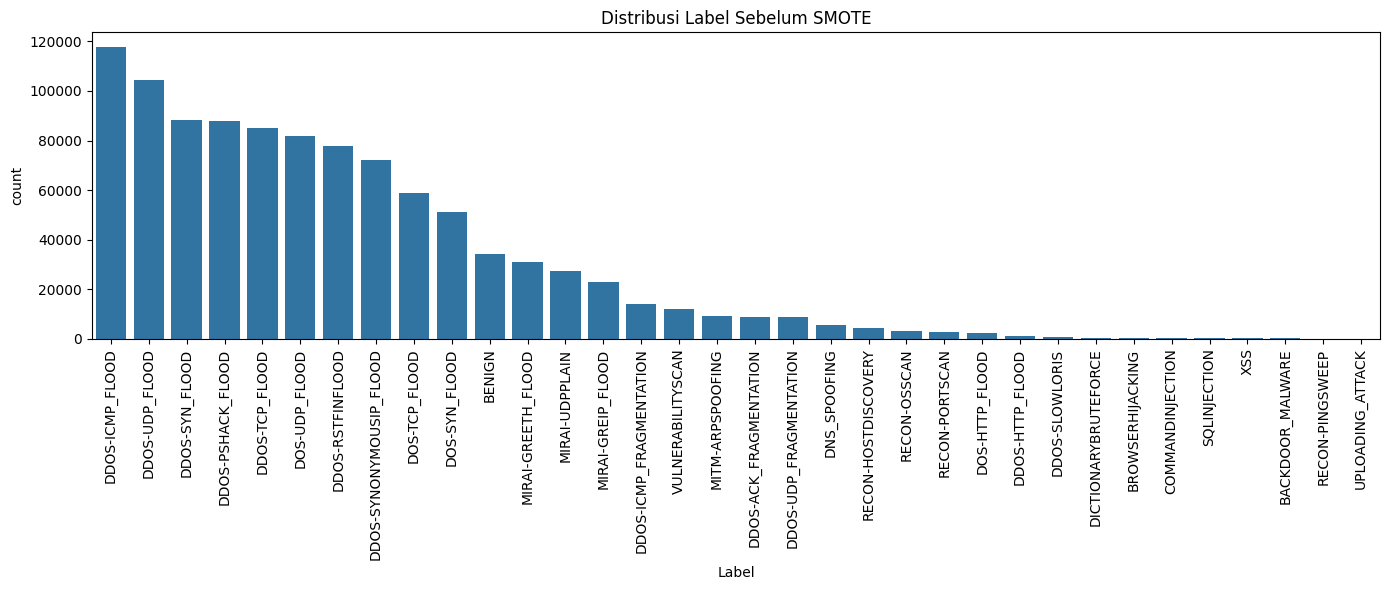

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribusi Label Sebelum SMOTE")
plt.tight_layout()
plt.show()

* Korelasi Fitur Terhadap Label Encoded

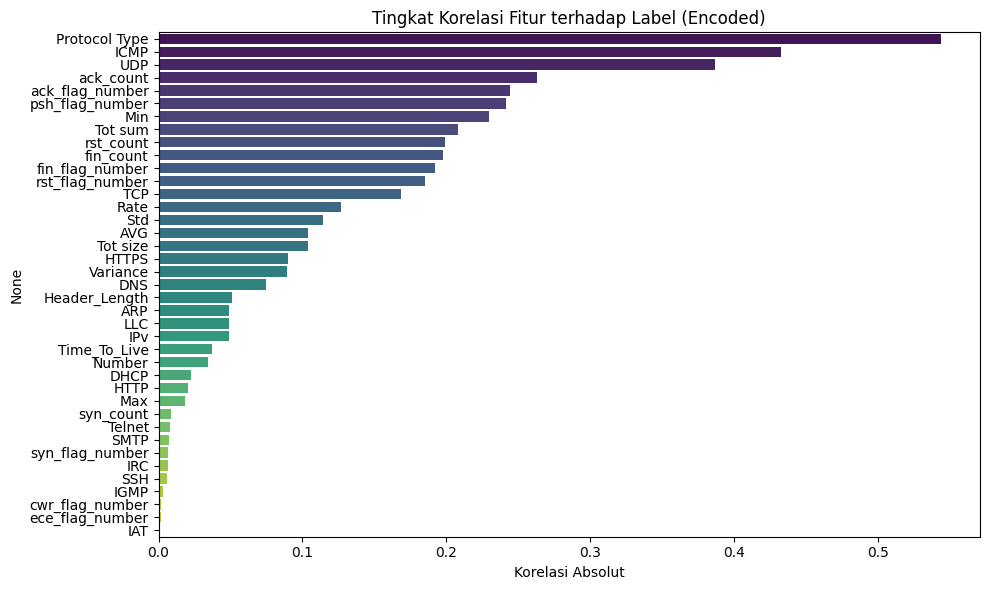

In [ ]:
corr = df.corr(numeric_only=True)
top_corr = corr['Label_encoded'].abs().sort_values(ascending=False).drop('Label_encoded').head(39)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, dodge=False, palette='viridis', legend=False)
plt.title("Tingkat Korelasi Fitur terhadap Label (Encoded)")
plt.xlabel("Korelasi Absolut")
plt.tight_layout()
plt.show()

**5. SMOTE (Synthetic Minority Over-sampling Technique)**

* Memisahkan Fitur (X) dan Label (y)

In [ ]:
X = df.drop(columns=['Label', 'Label_encoded'])  # fitur (semua kolom kecuali label)
y = df['Label_encoded']                          # label yang sudah diencode (Target)

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1014174, 39)
y shape: (1014174,)


* Penanganan Data Tidak Seimbang/Imbalance Data dengan SMOTE

In [ ]:
smote = SMOTE(random_state=42) #Inisialisasi SMOTE

In [ ]:
print(np.isinf(X).sum().sum())

10


In [ ]:
X.replace([np.inf, -np.inf], np.nan, inplace=True) # Ganti inf dan -inf dengan NaN

X.dropna(inplace=True) # Hapus baris yang mengandung NaN

y = y[X.index] # Mempastikan y tetap sinkron setelah drop baris di X

In [ ]:
print("Ada NaN lagi di X?", X.isnull().sum().sum())
print("Ada inf lagi di X?", np.isinf(X).sum().sum())

Ada NaN lagi di X? 0
Ada inf lagi di X? 0


In [ ]:
X_resampled, y_resampled = smote.fit_resample(X, y) #Menerapkan SMOTE pada X dan y

Load hasil Smote yang sudah tersimpan di google drive

In [ ]:
X_resampled = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/X_cleaned_before_boruta.pkl')
y_resampled = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/y_cleaned_before_boruta.pkl')

* Cek distribusi label setelah SMOTE

In [ ]:
print("Distribusi label setelah SMOTE:")
print(Counter(y_resampled))

Distribusi label setelah SMOTE:
Counter({8: 117769, 23: 117769, 21: 117769, 17: 117769, 6: 117769, 13: 117769, 12: 117769, 14: 117769, 25: 117769, 11: 117769, 20: 117769, 32: 117769, 19: 117769, 9: 117769, 1: 117769, 10: 117769, 7: 117769, 22: 117769, 26: 117769, 24: 117769, 29: 117769, 4: 117769, 15: 117769, 27: 117769, 0: 117769, 18: 117769, 33: 117769, 5: 117769, 2: 117769, 30: 117769, 16: 117769, 3: 117769, 28: 117769, 31: 117769})


In [ ]:
print("Jumlah Data Sebelum SMOTE:", X.shape)
print("Jumlah Data Sesudah SMOTE:", X_resampled.shape)

Jumlah Data Sebelum SMOTE: (1014164, 39)
Jumlah Data Sesudah SMOTE: (4004146, 39)


* Visualisasi Distribusi Label Setelah SMOTE

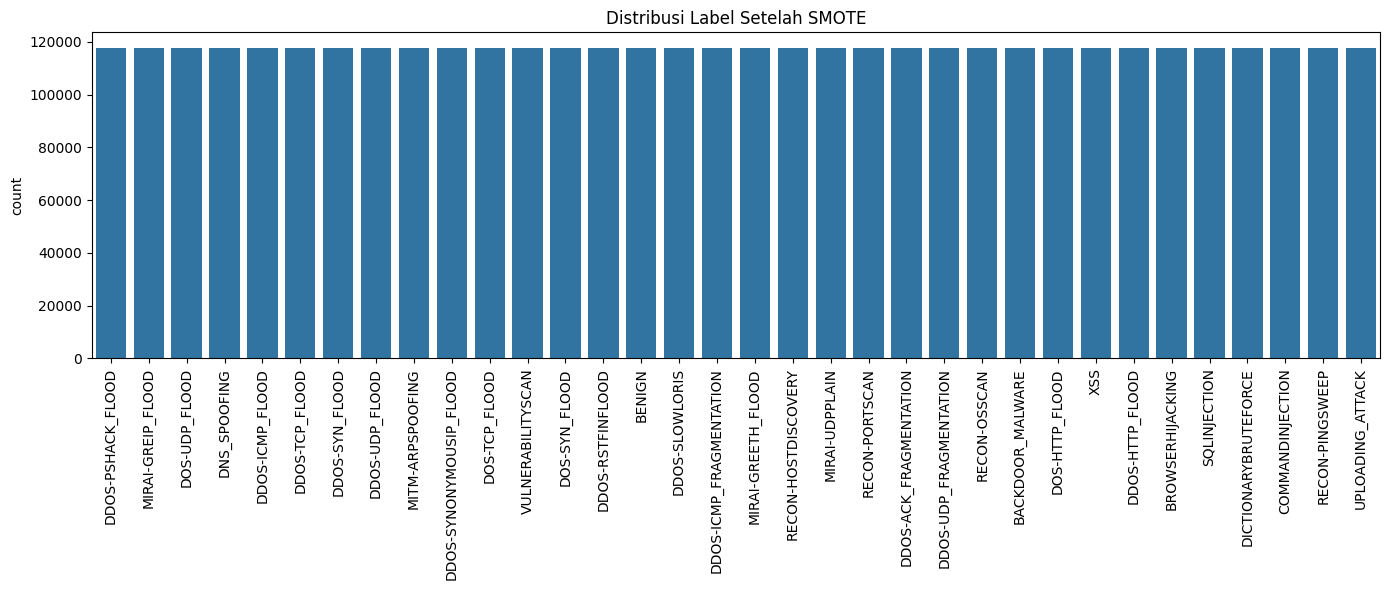

In [ ]:
inverse_mapping = {v: k for k, v in label_mapping.items()} # Mengubah mapping angka ke label Asli
y_resampled_label = [inverse_mapping[i] for i in y_resampled] # Mengubah y_resampled ke nama label

plt.figure(figsize=(14, 6))
sns.countplot(x=y_resampled_label, order=pd.Series(y_resampled_label).value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribusi Label Setelah SMOTE')
plt.tight_layout()
plt.show()

In [ ]:
print(df['Label'].value_counts()) #sebelum SMOTE
print(pd.Series(y_resampled_label).value_counts()) #sesudah SMOTE

Label
DDOS-ICMP_FLOOD            117769
DDOS-UDP_FLOOD             104475
DDOS-SYN_FLOOD              88430
DDOS-PSHACK_FLOOD           87726
DDOS-TCP_FLOOD              85038
DOS-UDP_FLOOD               81962
DDOS-RSTFINFLOOD            77708
DDOS-SYNONYMOUSIP_FLOOD     72245
DOS-TCP_FLOOD               58939
DOS-SYN_FLOOD               51236
BENIGN                      34186
MIRAI-GREETH_FLOOD          30791
MIRAI-UDPPLAIN              27497
MIRAI-GREIP_FLOOD           23023
DDOS-ICMP_FRAGMENTATION     14006
VULNERABILITYSCAN           11806
MITM-ARPSPOOFING             9079
DDOS-ACK_FRAGMENTATION       8938
DDOS-UDP_FRAGMENTATION       8793
DNS_SPOOFING                 5588
RECON-HOSTDISCOVERY          4221
RECON-OSSCAN                 2925
RECON-PORTSCAN               2578
DOS-HTTP_FLOOD               2356
DDOS-HTTP_FLOOD               906
DDOS-SLOWLORIS                733
DICTIONARYBRUTEFORCE          417
BROWSERHIJACKING              166
COMMANDINJECTION              157
SQLINJEC

Seleksi Fitur tahap awal

In [ ]:
# Cek fitur dengan 1 nilai unik
constant_columns = [col for col in X_resampled.columns if X_resampled[col].nunique() == 1]
print("Fitur konstan:", constant_columns)

Fitur konstan: []


In [ ]:
# Hapus jika ada
X_resampled.drop(columns=constant_columns, inplace=True)

In [ ]:
# Hitung korelasi
corr_matrix = X_resampled.corr().abs()

# Ambil korelasi di atas threshold (misal 0.98)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

print("Fitur berkorelasi tinggi:", to_drop)

Fitur berkorelasi tinggi: ['IPv', 'LLC', 'Tot size']


In [ ]:
# Hapus fitur mirip
X_resampled.drop(columns=to_drop, inplace=True)

**6. Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Akan menampilkan Ukuran data untuk training dan testing
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (3203316, 36)
X_test: (800830, 36)
y_train: (3203316,)
y_test: (800830,)


Load Hasil Split dari Google Drive

In [ ]:
# Data Training
X_train = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/y_train.pkl')

print("Loaded X_train:", X_train.shape)
print("Loaded y_train:", y_train.shape)

Loaded X_train: (3203316, 36)
Loaded y_train: (3203316,)


In [ ]:
# Data Testing
X_test  = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/X_test.pkl')
y_test  = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/y_test.pkl')

print("Loaded X_test:", X_test.shape)
print("Loaded y_test:", y_test.shape)

Loaded X_test: (800830, 36)
Loaded y_test: (800830,)


**7. Seleksi Fitur Menggunakan Boruta**

* Mengambil Sampel dari X_train untuk Boruta

In [ ]:
from sklearn.utils import resample

X_sampled, y_sampled = resample(
    X_train, y_train,
    n_samples=10000,
    random_state=42,
    stratify=y_train
)

print("Jumlah data yang digunakan Boruta:", X_sampled.shape)

Jumlah data yang digunakan Boruta: (10000, 36)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# Inisialisasi model Random Forest
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

# Inisialisasi Boruta
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', random_state=42)

# Jalankan Boruta
boruta_selector.fit(X_sampled.values, y_sampled)

# Ambil fitur yang terpilih
selected_features = X_sampled.columns[boruta_selector.support_].tolist()
print("Fitur terpilih oleh Boruta:", selected_features)


KeyboardInterrupt: 

In [ ]:
# Inisialisasi model Random Forest
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

In [ ]:
# Inisialisasi Boruta
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', random_state=42)

In [ ]:
# Jalankan Boruta
boruta_selector.fit(X_sampled.values, y_sampled)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=70, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x79EF16C20C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x79EF16C20C40)

In [ ]:
# Ambil fitur yang terpilih
selected_features = X_sampled.columns[boruta_selector.support_].tolist()
print("Fitur terpilih oleh Boruta:", selected_features)

Fitur terpilih oleh Boruta: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'HTTP', 'HTTPS', 'TCP', 'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [ ]:
#menyimpan hasil Boruta jika ada perubahan
joblib.dump(selected_features, '/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/boruta_selected_features.pkl')

['/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/boruta_selected_features.pkl']

Load Data Hasil Boruta

In [ ]:
# Untuk Membuat DataFrame fitur + ranking
ranking = boruta_selector.ranking_
feature_names = X_sampled.columns
support = boruta_selector.support_

In [ ]:
# Load daftar fitur yang dipilih oleh Boruta
selected_features = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/boruta_selected_features.pkl')

# Cek isi
print("Fitur hasil seleksi Boruta:", selected_features)

Fitur hasil seleksi Boruta: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'HTTP', 'HTTPS', 'TCP', 'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


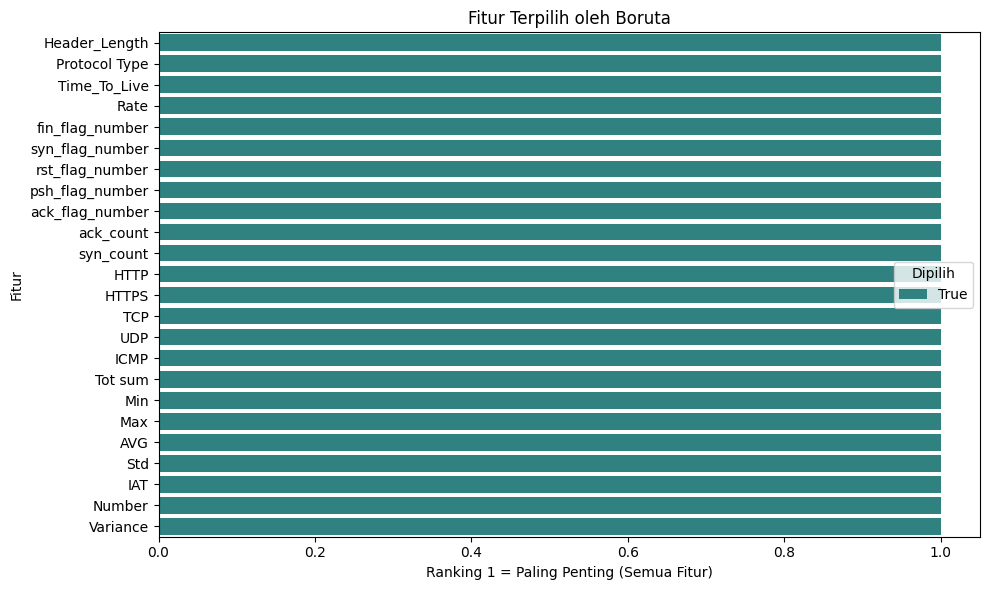

In [ ]:
# Untuk Membuat DataFrame fitur + ranking
ranking = boruta_selector.ranking_
feature_names = X_sampled.columns
support = boruta_selector.support_

# Untuk Membuat dataframe
boruta_result_df = pd.DataFrame({
    'Fitur': feature_names,
    'Ranking': ranking,
    'Dipilih': support
})

# Filter hanya fitur yang dipilih Boruta
selected_df = boruta_result_df[boruta_result_df['Dipilih'] == True]

# Urutkan berdasarkan ranking (Semua yang dipilih = 1)
selected_df = selected_df.sort_values(by='Ranking')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Fitur',
    x='Ranking',
    data=selected_df,
    hue='Dipilih',
    palette='viridis_r',
    dodge=False
)
plt.title("Fitur Terpilih oleh Boruta")
plt.xlabel("Ranking 1 = Paling Penting (Semua Fitur)")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

 fitur-fitur yang ditolak Boruta:

In [ ]:
boruta_result_df[boruta_result_df['Dipilih'] == False].sort_values(by='Ranking')

,Fitur,Ranking,Dipilih
13,fin_count,2,False
14,rst_count,3,False
25,ARP,4,False
17,DNS,5,False
20,SSH,6,False
24,DHCP,7,False
27,IGMP,8,False
21,IRC,9,False
9,ece_flag_number,10,False
10,cwr_flag_number,11,False


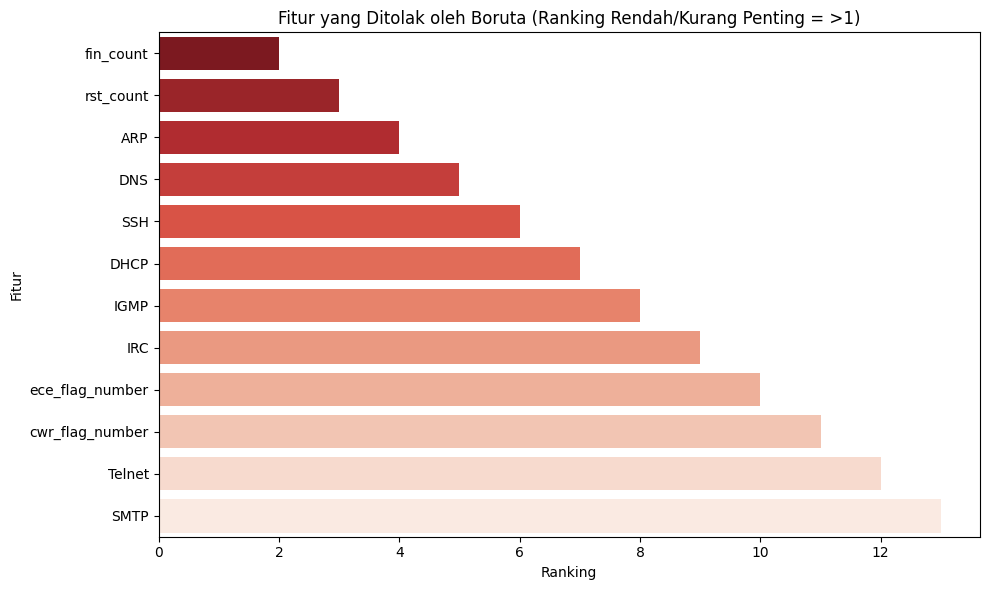

In [ ]:
# Buat DataFrame semua fitur dari Boruta
boruta_result_df = pd.DataFrame({
    'Fitur': X_sampled.columns,
    'Ranking': boruta_selector.ranking_,
    'Dipilih': boruta_selector.support_
})

# Filter fitur yang DITOLAK Boruta
rejected_df = boruta_result_df[boruta_result_df['Dipilih'] == False]
rejected_df = rejected_df.sort_values(by='Ranking', ascending=True)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    y='Fitur',
    x='Ranking',
    data=rejected_df,
    hue='Fitur',
    palette='Reds_r',
    dodge=False,
    legend=False
)
plt.title("Fitur yang Ditolak oleh Boruta (Ranking Rendah/Kurang Penting = >1)")
plt.xlabel("Ranking")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

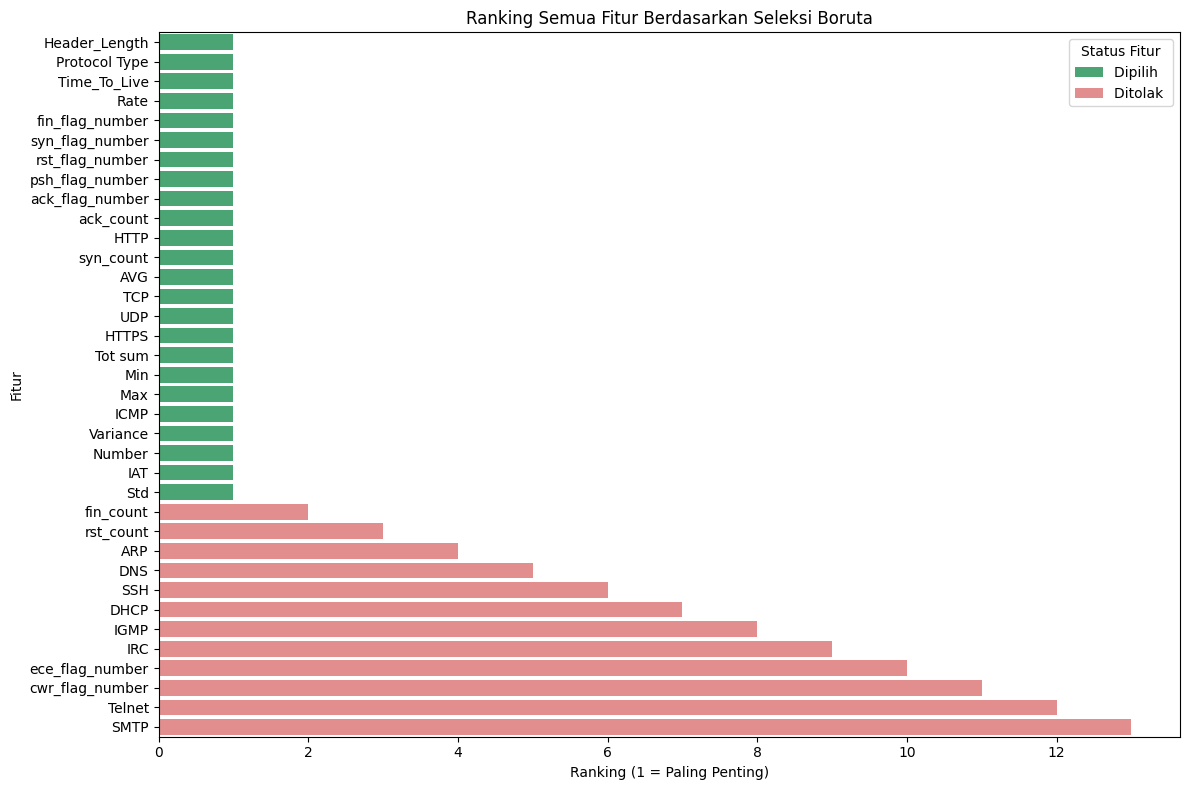

In [ ]:
# DataFrame lengkap: semua fitur + ranking + status
boruta_result_df = pd.DataFrame({
    'Fitur': X_sampled.columns,
    'Ranking': boruta_selector.ranking_,
    'Status': ['Dipilih ' if s else 'Ditolak ' for s in boruta_selector.support_]
})

# Urutkan berdasarkan ranking (semakin penting = atas)
boruta_result_df = boruta_result_df.sort_values(by='Ranking')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    y='Fitur', x='Ranking',
    hue='Status',
    data=boruta_result_df,
    dodge=False,
    palette={'Dipilih ': 'mediumseagreen', 'Ditolak ': 'lightcoral'}
)
plt.title("Ranking Semua Fitur Berdasarkan Seleksi Boruta")
plt.xlabel("Ranking (1 = Paling Penting)")
plt.ylabel("Fitur")
plt.legend(title='Status Fitur')
plt.tight_layout()
plt.show()

**8. Training Model**

In [ ]:
# Ambil hanya fitur terpilih oleh Boruta
X_train_selected = X_train[selected_features]
X_test_selected  = X_test[selected_features]

print("Ukuran X_train_selected:", X_train_selected.shape)
print("Ukuran X_test_selected:", X_test_selected.shape)

Ukuran X_train_selected: (3203316, 24)
Ukuran X_test_selected: (800830, 24)


In [ ]:
# Ambil 50 ribu data pertama
X_train_sampled = X_train_selected[:50000]
y_train_sampled = y_train[:50000]

print("Ukuran X_train_sampled:", X_train_sampled.shape)
print("Ukuran y_train_sampled:", y_train_sampled.shape)

Ukuran X_train_sampled: (50000, 24)
Ukuran y_train_sampled: (50000,)


In [ ]:
# Inisialisasi model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

In [ ]:
# Training dengan data lebih kecil
rf.fit(X_train_sampled, y_train_sampled)
print("Model berhasil dilatih dengan subset data!")

Model berhasil dilatih dengan subset data!


In [ ]:
import joblib

# Simpan model yang sudah dilatih
joblib.dump(rf, '/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/rfpercobaan1.pkl')

['/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/rfpercobaan1.pkl']

In [ ]:
import joblib

# Load model dari file
rf = joblib.load('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/rfpercobaan1.pkl')

**9. Evaluasi Model**


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     23554
           1       0.62      0.68      0.65     23554
           2       0.87      0.96      0.91     23554
           3       0.91      0.95      0.93     23554
           4       1.00      0.99      0.99     23554
           5       0.93      0.90      0.91     23554
           6       1.00      1.00      1.00     23554
           7       0.99      0.99      0.99     23554
           8       1.00      1.00      1.00     23553
           9       1.00      1.00      1.00     23554
          10       0.93      0.99      0.96     23554
          11       0.46      0.47      0.46     23554
          12       0.42      0.39      0.41     23554
          13       0.60      0.59      0.59     23554
          14       0.67      0.71      0.69     23554
          15       0.99      0.99      0.99     23553
          16       0.79      0.83      0.81     23554
   

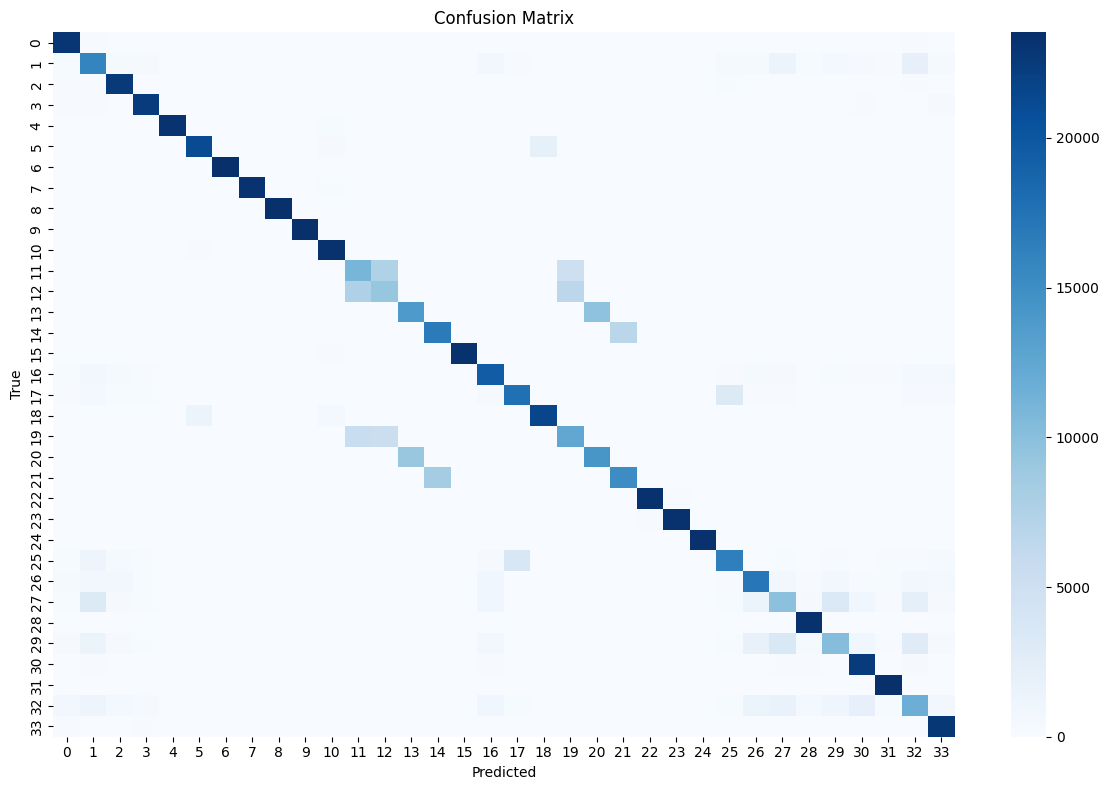

In [ ]:
# Prediksi pada data uji (full test set)
y_pred = rf.predict(X_test_selected)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**10. Interpretasi Model dengan SHAP (Explainable AI)**

In [ ]:
import shap

# Inisialisasi explainer khusus tree-based model
explainer = shap.TreeExplainer(rf)

In [ ]:
# Ambil sebagian data test
X_shap_sample = X_test_selected.sample(100, random_state=42)

In [ ]:
# STEP 1: Ambil ulang sampel dari X_test_selected
X_shap_sample = X_test_selected.sample(100, random_state=42)  # ← fitur Boruta

# STEP 2: Buat ulang explainer
explainer = shap.TreeExplainer(rf)

# STEP 3: HITUNG ULANG SHAP VALUES
shap_values = explainer.shap_values(X_shap_sample)


In [ ]:
print("SHAP shape:", np.array(shap_values[1]).shape)
print("DATA shape:", X_shap_sample.shape)

SHAP shape: (24, 34)
DATA shape: (100, 24)


In [ ]:
# Hitung nilai SHAP
shap_values = explainer.shap_values(X_shap_sample)

In [ ]:
type(shap_values)            # Harusnya: list
len(shap_values)             # Jumlah kelas → misalnya 34
np.array(shap_values[0]).shape  # Harus sama dengan X_shap_sample.shape

(24, 34)

Demo Model

In [ ]:
# Buat DataFrame gabungan
test_with_label = X_test_selected.copy()
test_with_label['Label'] = y_test.values  # gabungkan label

# Simpan ke file Excel
test_with_label.to_csv('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/X_test_selected_with_label.csv', index=False)

In [ ]:
# Mapping angka ke label asli
label_inverse_map = {v: k for k, v in label_mapping.items()}
test_with_label['Nama_Serangan'] = test_with_label['Label'].map(label_inverse_map)

# Simpan ulang
test_with_label.to_csv('/content/drive/MyDrive/Dataset/CICIoT_Dataset2023/X_test_selected_with_label.csv', index=False)

In [ ]:
# Ambil 3 baris dari data TESTING
sample_indices = [13, 12, 11]
sample = X_test_selected.iloc[sample_indices]

# Prediksi
predictions = rf.predict(sample)

# Mapping ke nama serangan (label asli)
label_inverse_map = {v: k for k, v in label_mapping.items()}
decoded_preds = [label_inverse_map[p] for p in predictions]

# Tampilkan hasil demo
print("Hasil Prediksi Demo:")
for i, pred in zip(sample_indices, decoded_preds):
    print(f"Baris ke-{i} → {pred}")


Hasil Prediksi Demo:
Baris ke-13 → COMMANDINJECTION
Baris ke-12 → MIRAI-UDPPLAIN
Baris ke-11 → DDOS-SYNONYMOUSIP_FLOOD


In [ ]:
import pandas as pd

# Gabungkan hasil ke tabel
hasil_demo = pd.DataFrame({
    "Index (Python)": sample_indices,
    "Baris Excel": [i+1 for i in sample_indices],
    "Prediksi": decoded_preds
})

print(hasil_demo)

   Index (Python)  Baris Excel                 Prediksi
0              13           14         COMMANDINJECTION
1              12           13           MIRAI-UDPPLAIN
2              11           12  DDOS-SYNONYMOUSIP_FLOOD
